# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame input | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,1408] | 0.1|
 


<div style="overflow-x: auto;">

## PSPI from (Action Units)
Pain expression is widely characterized by the activation of a small set of facial muscles and coded by a set of
corresponding actions units (AUs): 
| Action units  | Meaning              | Range   |
|----------------|----------------------|---------|
| AU 4          | brow lowering        | 0 to 5  |
| AU 6 and AU 7 | orbital tightening   | 0 to 5  |
| AU 9 and AU 10| levator labii raise  | 0 to 5  |
| AU 43         | eye closure          | 0 or 1  |
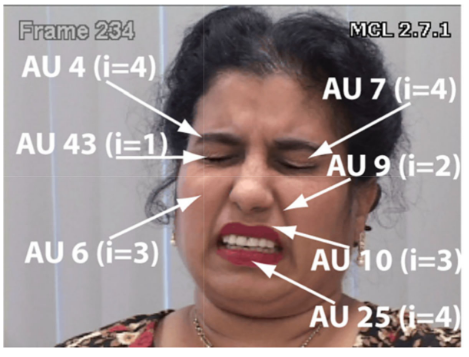

STEPS for preprocessing:
1) Align faces by fixing the inter-ocular distance.
2) Compute mean facial shape by averaging all of the landmark points in the roughly aligned faces.
3) Warp each face in the database to the average face using piece-wise linear warping,where the facial pieces are formed using Delaunay triangulation.
4) Crop out the normalized faces by forming a mask with the convex hull of the landmark points resulting in 224×224 images

# COde

'villi-Inspiron-16-Plus-7620'

In [13]:
import torch
import torchvision.transforms as T
import cv2

def preprocess_images(tensors):
  """
  Preprocess a batch of image tensors and plot the preprocessed images.
  
  Args:
      tensors (torch.Tensor): A tensor of shape (B, C, H, W) where:
                              B = batch size,
                              C = number of channels,
                              H = height,
                              W = width.
  
  Returns:
      torch.Tensor: Preprocessed tensor of shape (B, C, 224, 224).
  """
  crop_size = (224, 224)
  rescale_factor = 0.00392156862745098  # 1/255
  image_mean = [0.485, 0.456, 0.406]
  image_std = [0.229, 0.224, 0.225]
  shortest_edge = 224
  
  transform = T.Compose([
    T.Resize(shortest_edge),  # Resize the shortest edge to 224, preserving aspect ratio
    T.CenterCrop(crop_size),  # Center crop
    T.Lambda(lambda x: x * rescale_factor),  # Rescale (1/255)
    T.Normalize(mean=image_mean, std=image_std)  # Normalize,
  ])
  
  preprocessed_tensors = torch.stack([transform(t) for t in tensors])
  return preprocessed_tensors

def read_video(video_path):
  """
  Read a video file and return a tensor.
  
  Args:
      video_path (str): Path to the video file.
  
  Returns:
      torch.Tensor: Tensor of shape (T, H, W, C).
  """
  video = cv2.VideoCapture(video_path)
  frames = []
  while True:
    ret, frame = video.read()
    if not ret:
      break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
  video.release()
  return torch.tensor(frames).permute(0, 3, 1, 2) # (T, H, W, C) -> (T, C, H, W)

def uniform_sampling(video_tensor, num_frames):
  """
  Uniformly sample `num_frames` frames from the video tensor.
  
  Args:
      video_tensor (torch.Tensor): Tensor of shape (T, C, H, W).
      num_frames (int): Number of frames to sample.
  
  Returns:
      torch.Tensor: Tensor of shape (num_frames, C, H, W).
  """
  T = video_tensor.size(0)
  indices = torch.linspace(0, T - 1, num_frames).round().long()
  return video_tensor[indices]

def stride_sampling(video_tensor,stride, num_frames):
  """
  Stride sample `num_frames` frames from the video tensor.
  
  Args:
      video_tensor (torch.Tensor): Tensor of shape (T, C, H, W).
      num_frames (int): Number of frames to sample.
  
  Returns:
      torch.Tensor: Tensor of shape (num_frames, C, H, W).
  """
  T = video_tensor.size(0)
  start_idx = torch.randint(0, T - stride*num_frames, (1,)).item()
  indices = torch.arange(start_idx, start_idx + stride*num_frames, stride)
  return video_tensor[indices]

def get_clips(video_tensor, num_frames_per_clip, num_clips,stride):
  """
  Split the video tensor into clips.
  
  Args:
      video_tensor (torch.Tensor): Tensor of shape (T, C, H, W).
      num_frames_per_clip (int): Number of frames in each clip.
      num_clips (int): Number of clips to sample.
  
  Returns:
      torch.Tensor: Tensor of shape (num_clips, num_frames_per_clip, C, H, W).
  """
  clips = []
  for _ in range(num_clips):
    clip = stride_sampling(video_tensor, stride, num_frames_per_clip)
    clips.append(clip)
  return torch.stack(clips)

def fix_seeds(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.enabled = False

In [ ]:
from custom.backbone import video_backbone
from custom.helper import MODEL_TYPE
from custom.dataset import customDataset
import os 
import numpy as np
import torch.nn.functional as F
import tqdm


model = video_backbone(model_type = MODEL_TYPE.VIDEOMAE_v2_S,remove_head=False)
dataset_path = os.path.join("toy_dataset", "Weizmann_dataset")
classes = os.listdir(dataset_path)
# print(classes)
list_video_path = []
list_labels = []
for c in classes:
  class_path = os.path.join(dataset_path, c)
  for video in os.listdir(class_path):
    list_video_path.append(os.path.join(class_path, video))
    list_labels.append(c)
list_results = [] 
range_len = range(len(list_video_path))
fix_seeds()
for batch in tqdm.tqdm(range_len):
  video_frames = read_video(list_video_path[batch])
  video_tensor = preprocess_images(video_frames)
  # video_tensor = stride_sampling(video_tensor,2 ,16).unsqueeze(0)
  video_tensor = get_clips(video_tensor=video_tensor,
                           num_frames_per_clip=16,
                           num_clips=8,
                           stride=2)
  video_tensor = video_tensor.permute(0, 2, 1, 3, 4)
  model.model.eval()
  with torch.no_grad():
    video_embedding = model.model.forward(video_tensor) # nr_clips, channels, nr_frames=16, H, W
  mean_softmax = torch.mean(F.softmax(video_embedding, dim=1), dim=0)
  prediction = torch.argmax(mean_softmax,dim=0).detach().cpu().item()
  list_results.append(prediction)
  del video_tensor

100%|██████████| 93/93 [09:13<00:00,  5.95s/it]


In [22]:
with open("k710_labels/k710_label_map.txt",'r') as f:
  label_map = f.readlines()
  label_map = [x.strip() for x in label_map]
  print(len(label_map))
  print(label_map)
label_map = np.array(label_map)

710
['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer', 'auctioning', 'baby waking up', 'baking cookies', 'inflating balloons', 'bandaging', 'barbequing', 'bartending', 'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing', 'bending back', 'bending metal', 'biking through snow', 'blasting sand', 'blowing glass', 'blowing leaves', 'blowing nose', 'blowing out candles', 'bobsledding', 'bookbinding', 'bouncing on trampoline', 'bowling', 'braiding hair', 'breading or breadcrumbing', 'breakdancing', 'brush painting', 'brushing hair', 'brushing teeth', 'building cabinet', 'building shed', 'bungee jumping', 'busking', 'canoeing or kayaking', 'capoeira', 'carrying baby', 'cartwheeling', 'carving pumpkin', 'catching fish', 'catching or throwing baseball', 'catching or throwing frisbee', 'catching or throwing softball', 'celebrating', 'changing oil', 'changing wheel (not on bike)', '

In [10]:
import custom.tools as tools
path_features = 'partA/video/features/samples_16_frontalized'
dict_data = tools.load_dict_data(path_features)

In [11]:
dict_data['list_sample_id']
target_sample_id = torch.tensor([3,6,1300])
is_in = torch.isin(dict_data['list_sample_id'],target_sample_id)
# torch.sum(is_in)

In [5]:
import custom.dataset as dataset

path_features = 'partA/video/features/samples_16_frontalized'
ds = dataset.customDatasetWhole(path_to_extracted_features=path_features,
                             csv_path='_test_attentive/history_run_1_1741730027/1741730029960_VIDEOMAE_v2_S_NONE_NONE_SLIDING_WINDOW_ATTENTIVE/train_ATTENTIVE/k1_cross_val/k1_cross_val_sub_0/train.csv',
                             concatenate_temporal=True)
el = [ds.__getitem__(0),ds.__getitem__(20),ds.__getitem__(50)]
packed_input,_,_ = ds._custom_collate(el)

In [7]:
[e['subject_id'] for e in el]

[tensor(1, dtype=torch.int16),
 tensor(1, dtype=torch.int16),
 tensor(3, dtype=torch.int16)]

In [2]:
packed_input.data.shape

torch.Size([24, 6144])

In [4]:
for k,v in dict_data.items():
  print(k,v.shape)

list_labels torch.Size([69336])
features torch.Size([69336, 8, 1, 1, 768])
list_path (69336,)
list_sample_id torch.Size([69336])
list_frames torch.Size([69336, 16])
list_subject_id torch.Size([69336])


In [ ]:
import pickle 
pkl_path = "/media/villi/TOSHIBA EXT/video_Test/test_Mar_21/history_run_GRU100_1741962146/1741980821770_VIDEOMAE_v2_B_NONE_NONE_SLIDING_WINDOW_ATTENTIVE/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data_1 = pickle.load(f)





/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

In [37]:
label_prediction_dict = {}
np_labels = np.array(list_labels)
class_results = np.array(list_results)
for label in np.unique(np_labels):
  # print(f"Label: {label}, Prediction: {prediction}")
  mask = (np_labels == label)
  masked_results  = class_results[mask]
  label_prediction_dict[label] = masked_results
prediction_to_label = {k:(list(zip(label_map[np.unique(v)],np.unique(v,return_counts=True)[1]))) for k,v in label_prediction_dict.items()}
for k,v in prediction_to_label.items():
  print(f'{k}: {v}')
accuracy_dict = {}
for label in label_prediction_dict:
  count_prediction = np.bincount(label_prediction_dict[label])
  accuracy_dict[label] = count_prediction.max().item() / count_prediction.sum().item()
print('\nAccuracy dict:')
for k,v in accuracy_dict.items():
  print(f'  {k}: {v}')
print('Mean accuracy:', np.mean(list(accuracy_dict.values())))


bend: [('fixing hair', 4), ('pushing cart', 1), ('tying necktie', 3), ('standing on hands', 1)]
jack: [('jumping jacks', 9)]
jump: [('sword fighting', 1), ('tiptoeing', 8)]
pjump: [('cooking chicken', 6), ('disc golfing', 1), ('tiptoeing', 1), ('jumping jacks', 1)]
robust_view: [('fixing hair', 2), ('ripping paper', 1), ('weaving basket', 7)]
side: [('weaving basket', 1), ('tiptoeing', 7), ('acting in play', 1)]
skip: [('playing harmonica', 9), ('tiptoeing', 1)]
walk: [('texting', 1), ('weaving basket', 3), ('tiptoeing', 3), ('moon walking', 3)]
wave1: [('fixing hair', 1), ('pushing car', 5), ('riding unicycle', 3)]
wave2: [('fixing hair', 1), ('pushing car', 8)]

Accuracy dict:
  bend: 0.4444444444444444
  jack: 1.0
  jump: 0.8888888888888888
  pjump: 0.6666666666666666
  robust_view: 0.7
  side: 0.7777777777777778
  skip: 0.9
  walk: 0.3
  wave1: 0.5555555555555556
  wave2: 0.8888888888888888
Mean accuracy: 0.7122222222222222


In [4]:
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import custom.tools as tools

feature_frontalized_path = "partA/video/features/samples_16_frontalized"
feature_frontalized = tools.load_dict_data(feature_frontalized_path)
feature_frontalized_new_path = "partA/video/features/samples_16_frontalized_new"
feature_frontalized_new = tools.load_dict_data(feature_frontalized_new_path)


/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

Unsupported file format: config_dict.pkl
Unsupported file format: config_dict.txt


In [5]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
list_unique_sample_id = np.unique(feature_frontalized['list_sample_id'])
list_cosine_similarity = []
for sample_id in list_unique_sample_id:
  mask = feature_frontalized['list_sample_id'] == sample_id
  mask_new = feature_frontalized_new['list_sample_id'] == sample_id
  feature_old = feature_frontalized['features'][mask].reshape(feature_frontalized['features'][mask].shape[0],-1)
  feature_new = feature_frontalized_new['features'][mask_new].reshape(feature_frontalized_new['features'][mask_new].shape[0],-1)
  cosine_sim = cosine_similarity(feature_old,feature_new)
  list_cosine_similarity.append(cosine_sim.min())
  # print(f"Sample id: {sample_id}, cosine similarity: {cosine_sim.mean()}")
list_cosine_similarity = np.array(list_cosine_similarity)

In [6]:
np.sort(list_cosine_similarity)[:20] 

array([0.36892933, 0.37708673, 0.38162476, 0.38852417, 0.39066643,
       0.39077565, 0.39587265, 0.39788944, 0.39798036, 0.39992392,
       0.40093282, 0.4059276 , 0.41331398, 0.41999918, 0.4223701 ,
       0.42329535, 0.4262716 , 0.4265301 , 0.430439  , 0.43271464],
      dtype=float32)

In [ ]:
# zip_list = list(zip(list_unique_sample_id,list_cosine_similarity))
mask_2701_2800 = (list_unique_sample_id >= 2701) & (list_unique_sample_id < 2801) # 082414_m_64
list_cosine_similarity[mask_2701_2800]

array([0.782539  , 0.7623574 , 0.7699763 , 0.74609405, 0.7919344 ,
       0.81570613, 0.828612  , 0.8448473 , 0.75115454, 0.7311841 ,
       0.77394843, 0.86282367, 0.83102554, 0.817842  , 0.6955457 ,
       0.7700049 , 0.8412597 , 0.6386234 , 0.7494948 , 0.7915889 ,
       0.7725155 , 0.7181214 , 0.7400994 , 0.85947615, 0.7668881 ,
       0.811051  , 0.8453315 , 0.8145913 , 0.78123355, 0.73129076,
       0.754594  , 0.8396774 , 0.81551874, 0.84689534, 0.74302757,
       0.6550234 , 0.7626867 , 0.8099638 , 0.7752123 , 0.7490816 ,
       0.74327743, 0.75850433, 0.7644745 , 0.81607705, 0.8102581 ,
       0.830031  , 0.7986455 , 0.7939112 , 0.78818953, 0.82565707,
       0.8232892 , 0.84649765, 0.8107133 , 0.79783964, 0.7898621 ,
       0.81891304, 0.7745934 , 0.791517  , 0.80464065, 0.6763696 ,
       0.7621292 , 0.7862116 , 0.73516554, 0.76170146, 0.73550457,
       0.7045983 , 0.8123125 , 0.8333515 , 0.8010185 , 0.69744337,
       0.7561288 , 0.808738  , 0.7412409 , 0.8159907 , 0.82718

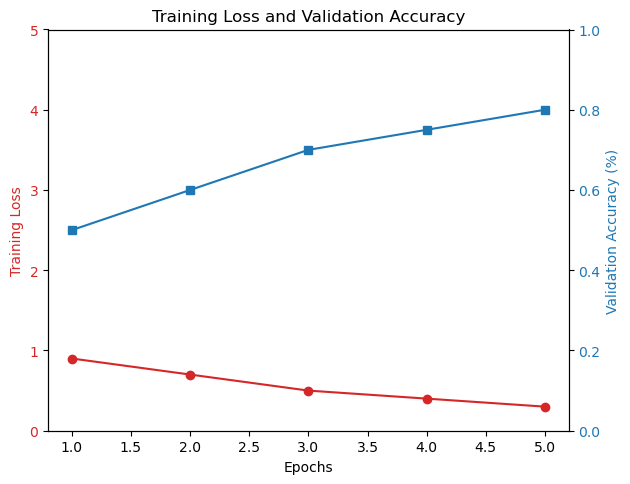

In [5]:
import matplotlib.pyplot as plt

# Example data
epochs = [1, 2, 3, 4, 5]
train_loss = [0.9, 0.7, 0.5, 0.4, 0.3]
val_accuracy = [.50, .60, .70, .75, .80]  # In percentage

fig, ax1 = plt.subplots()

# Plot training loss
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss", color="tab:red")
ax1.plot(epochs, train_loss, marker="o", color="tab:red", label="Train Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")
ax1.set_ylim([0, 5])
ax1.
# Create second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Validation Accuracy (%)", color="tab:blue")
ax2.plot(epochs, val_accuracy, marker="s", color="tab:blue", label="Val Accuracy")
ax2.tick_params(axis="y", labelcolor="tab:blue")
ax2.set_ylim([0, 1])

# Show plot
fig.tight_layout()
plt.title("Training Loss and Validation Accuracy")
plt.show()


In [ ]:
import pickle

pkl_path = "/media/villi/TOSHIBA EXT/video_Test/test_Mar_21/history_run_concat_ATTENTIVE_ultron_1742226356/1742252022496_VIDEOMAE_v2_B_NONE_NONE_SLIDING_WINDOW_ATTENTIVE/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data_1 = pickle.load(f)


/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

In [ ]:
k_0_0 = data_1['k0_cross_val_sub_0_train_val']
for k,v in k_0_0.items():
  if isinstance(v,int):
    print(k,v)
  else:
    print(k,len(v))

train_losses 500
train_loss_per_class 11
train_loss_per_subject 11
val_losses 500
val_loss_per_class 11
val_loss_per_subject 11
y_unique 5
train_unique_subject_ids 29
train_count_subject_ids 29
val_unique_subject_ids 29
val_count_subject_ids 29
train_unique_y 5
val_unique_y 5
subject_ids_unique 58
train_confusion_matricies 11
val_confusion_matricies 11
best_model_idx 178
list_train_macro_accuracy 500
list_val_macro_accuracy 500
epochs 499


7092485
Activation shape: torch.Size([8, 1, 768])


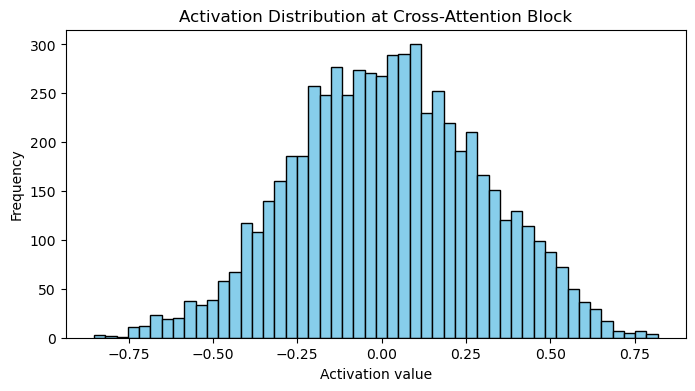

In [3]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('jepa')
from jepa.src.models.attentive_pooler import AttentiveClassifier
att_classifier = AttentiveClassifier(num_classes=5,pos_enc=True)
num_params = sum(p.numel() for p in att_classifier.parameters())
print(num_params)
x_sample = torch.randn(2,3,768)
att_classifier(x_sample)
x_sample = torch.randn(2,5,768)
att_classifier(x_sample)

# Dictionary to store activations from the hook.
activations = {}

def activation_hook(module, input, output):
    # Save the output (detach to avoid keeping the computation graph)
    activations['attn_out'] = output.detach()

# Register the forward hook on the cross_attention_block.
# If you want to monitor the final output of the cross-attention block, register it on that module.
hook_handle = att_classifier.pooler.cross_attention_block.register_forward_hook(activation_hook)

# Run a forward pass with your input (make sure your input x is of shape [B, T, C]).
dummy_input = torch.randn(8, 196, 768)  # Example: batch size 8, sequence length 196, embedding size 768.
_ = att_classifier(dummy_input)

# Now extract the activations.
attn_activations = activations.get('attn_out')
if attn_activations is None:
    print("No activations captured. Check your hook registration.")
else:
    print("Activation shape:", attn_activations.shape)
    # Flatten and convert to CPU numpy array for plotting.
    act_flat = attn_activations.view(-1).cpu().numpy()
    plt.figure(figsize=(8, 4))
    plt.hist(act_flat, bins=50, color='skyblue', edgecolor='black')
    plt.title("Activation Distribution at Cross-Attention Block")
    plt.xlabel("Activation value")
    plt.ylabel("Frequency")
    plt.show()

# Remove the hook to avoid unwanted effects in further passes.
hook_handle.remove()


In [4]:
import custom.head as head
attentive_head = head.AttentiveClassifierJEPA(num_classes=5,num_heads=8,embed_dim=1409)
# count params in attentive head
num_params = sum(p.numel() for p in attentive_head.parameters())
print(num_params)
name_params = [name for name, param in attentive_head.named_parameters()]

23850148


['pooler.query_tokens',
 'pooler.cross_attention_block.norm1.weight',
 'pooler.cross_attention_block.norm1.bias',
 'pooler.cross_attention_block.xattn.q.weight',
 'pooler.cross_attention_block.xattn.q.bias',
 'pooler.cross_attention_block.xattn.kv.weight',
 'pooler.cross_attention_block.xattn.kv.bias',
 'pooler.cross_attention_block.xattn.proj.weight',
 'pooler.cross_attention_block.xattn.proj.bias',
 'pooler.cross_attention_block.norm2.weight',
 'pooler.cross_attention_block.norm2.bias',
 'pooler.cross_attention_block.mlp.fc1.weight',
 'pooler.cross_attention_block.mlp.fc1.bias',
 'pooler.cross_attention_block.mlp.fc2.weight',
 'pooler.cross_attention_block.mlp.fc2.bias',
 'linear.weight',
 'linear.bias']

In [11]:
l1_norm = sum(param.abs().sum() for param in attentive_head.parameters() if param.requires_grad and not 'bias' in name_params)
l1_norm_tot = sum(param.abs().sum() for param in attentive_head.parameters() if param.requires_grad)

tensor(336772.0938, grad_fn=<AddBackward0>)
tensor(336772.0938, grad_fn=<AddBackward0>)


In [14]:
import pandas as pd

csv_path = "partA/starting_point/samples_exc_no_detection.csv"
df = pd.read_csv(csv_path,sep='\t')
filter_ = {
  'class_id':[0,3]
}
new_df = df[df['class_id'].isin(filter_['class_id'])]
# set class id 4 to 1
new_df['class_id'] = new_df['class_id'].replace(filter_['class_id'][1],1)
new_df.to_csv(f"partA/starting_point/samples_exc_no_detection_{filter_['class_id'][0]}_{filter_['class_id'][1]}.csv",index=False,sep='\t')

/tmp/ipykernel_313129/1632475640.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['class_id'] = new_df['class_id'].replace(filter_['class_id'][1],1)


In [2]:
import custom.tools as tools
dict_data = tools.load_dict_data("/media/villi/TOSHIBA EXT/samples_16_frontalized_new_giant_hflip")
dict_data['list_sample_id']

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

Unsupported file format: config_dict.pkl
Unsupported file format: config_dict.txt


tensor([ 8701,  8701,  8701,  ..., 17400, 17400, 17400], dtype=torch.int32)

In [16]:
import pandas as pd
import custom.helper as helper
stoic = helper.stoic_subjects
csv_path = "partA/starting_point/samples_exc_no_detection.csv"
df = pd.read_csv(csv_path,sep='\t')
key = 'subject_id'
all_subjects = df[key].unique()
no_stoic = [s for s in all_subjects if s not in stoic]
filter_ = {
  key: no_stoic
}
new_df = df[df[key].isin(filter_[key])]
new_df.to_csv(f"partA/starting_point/samples_exc_no_detection_no_stoic.csv",index=False,sep='\t')

In [2]:
ref_landmarks

{'mean_facial_landmarks': array([[0.49868718, 0.5949711 , 0.563352  ],
        [0.5       , 0.5       , 0.5       ],
        [0.49885073, 0.52744806, 0.56198704],
        ...,
        [0.6217906 , 0.32362518, 0.64869684],
        [0.5974665 , 0.34300464, 0.64866465],
        [0.61985403, 0.3645303 , 0.64866865]], dtype=float32),
 'count_subject': 87}

In [1]:
from custom.faceExtractor import FaceExtractor
import cv2
import pickle
face_extractor = FaceExtractor(visionRunningMode='image')
image_path = "new_image/img.png"

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ref_landmarks_path = "partA/video/mean_face_landmarks_per_subject/all_subjects_mean_landmarks.pkl"
with open(ref_landmarks_path, 'rb') as f:
  ref_landmarks = pickle.load(f)
dict_result = face_extractor.frontalize_img(frame=img,ref_landmarks=ref_landmarks['mean_facial_landmarks'])

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

landmarks: [[[ 0.53349113  0.73721206 -0.04900459]
  [ 0.56110024  0.64085484 -0.11650103]
  [ 0.53716546  0.66280329 -0.0548819 ]
  ...
  [ 0.64282316  0.44705456  0.05618581]
  [ 0.62781429  0.46424106  0.05615493]
  [ 0.64082229  0.4851304   0.05616147]]]
rigid_transform_3D: A.shape: (3, 478), B.shape: (3, 478)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1743692217.884175  365424 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1743692217.952444  365424 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


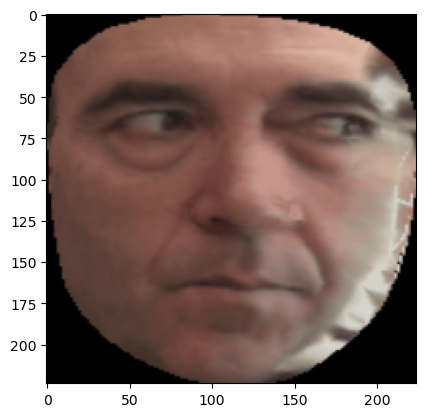

In [4]:
import matplotlib.pyplot as plt
plt.imshow(dict_result['frontalized_img'])
# dict_result['frontalized_img']

In [7]:
import pickle
pkl_path="history_run_1_96404_ATTENTIVE_JEPA_villi-Inspiron-16-Plus-7620_1743712318/1743712318371_VIDEOMAE_v2_B_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)
data['results'].keys()

dict_keys(['k0_cross_val_sub_0'])

In [19]:
df_path_2 = "/media/villi/TOSHIBA EXT/test_video/test_Apr_04/pre_test_drop_posEmb/_summary/plot_run_details/summary.csv"
df_2 = pd.read_csv(df_path_2)
input_path = "/media/villi/TOSHIBA EXT/test_video/test_Apr_04/test_drop_posEmb_smooth/_summary/plot_run_details/summary.csv"
df = pd.read_csv(input_path)
concatenate_df = pd.concat([df, df_2], axis=0)
concatenate_df.to_csv("summary_concat.csv",index=False)

In [44]:
import numpy as np
import pandas as pd

def process_summary_csv(
  df,
  output_csv_path="df_filtered.csv",
  filter_vals={'reg_lambda_L1': 0.00001, 'reg_lambda_L2': 0},
  fixed_col=['label_smooth'],
  hyper_cols=['ATTENTIVE_JEPA.dropout', 'ATTENTIVE_JEPA.attn_dropout', 'ATTENTIVE_JEPA.residual_dropout','ATTENTIVE_JEPA.pos_enc'],
  metric=['total_mean_val_accuracy_best_ep'],
  additional_cols=['total_mean_test_accuracy_best_ep']
):
  """
  Processes the summary CSV file by filtering rows based on fixed parameter values,
  selecting specific columns, grouping by unique hyperparameter values, and calculating
  the difference in the specified metric between the best and worst cases for each group.

  Parameters:
    input_csv_path (str): Path to the input CSV file.
    output_csv_path (str): Path to save the output CSV file. Defaults to "df_filtered.csv".
    fixed_vals (dict): Dictionary of column names and their fixed values for filtering.
    tmp_cols (list): List of temporary column names to include.
    hyper_cols (list): List of hyperparameter column names to group by.
    metric (list): List containing the metric column name used for determining best and worst rows.
    additional_cols (list): List of additional columns to include from the CSV.

  Returns:
    pd.DataFrame: A DataFrame with the filtered, processed, and sorted results.
  """
  cols_to_show = additional_cols[:1] + hyper_cols + fixed_col + additional_cols[1:] + metric

  df_filtered = df.copy()
  for col, val in filter_vals.items():
    df_filtered = df_filtered[df_filtered[col] == val]

  df_filtered = df_filtered[cols_to_show]
  hyper_values = df_filtered[hyper_cols].values
  
  unique_hyper_configs = np.unique(hyper_values.astype(np.float64), axis=0)

  processed_rows = []
  new_columns = cols_to_show + ['diff_validation']
  for i,col in enumerate(new_columns):
    split_cols = col.split('.')
    new_columns[i] = split_cols[-1]
  for config in unique_hyper_configs:
    mask = np.all(hyper_values == config, axis=1)
    subset = df_filtered.loc[mask]

    best_row = subset.loc[subset[metric].idxmax()]
    worst_row = subset.loc[subset[metric].idxmin()]
    metric_diff = np.round(best_row[metric].values - worst_row[metric].values, 4)

    new_row = best_row.copy()
    new_row['diff_validation'] = metric_diff[0]
    processed_rows.append(new_row.values.reshape(-1))

  df_result = pd.DataFrame(processed_rows, columns=new_columns)
  df_result.sort_values(by=metric, ascending=False, inplace=True)
  df_result.to_csv(output_csv_path, index=False)

  return df_result

# Example usage
if __name__ == "__main__":
  output_csv_path="df_filtered.csv",
  # filter_vals={'reg_lambda_L1': 0.00001, 'reg_lambda_L2': 0}
  filter_vals={}
  fixed_col=['ATTENTIVE_JEPA.dropout']
  hyper_cols=['label_smooth', 'ATTENTIVE_JEPA.attn_dropout', 'ATTENTIVE_JEPA.residual_dropout','ATTENTIVE_JEPA.pos_enc','reg_lambda_L1','reg_lambda_L2']
  metric=['total_mean_val_accuracy_best_ep']
  additional_cols=['total_mean_test_accuracy_best_ep']
  df_new = process_summary_csv(df=concatenate_df,additional_cols=additional_cols,
                              filter_vals=filter_vals,
                              fixed_col=fixed_col,
                              hyper_cols=hyper_cols,
                              metric=metric)

df_new


,total_mean_test_accuracy_best_ep,label_smooth,attn_dropout,residual_dropout,pos_enc,reg_lambda_L1,reg_lambda_L2,dropout,total_mean_val_accuracy_best_ep,diff_validation
25,0.319888,0.2,0.5,0.0,False,0.00001,0.0000,0.3,0.447994,0.1333
27,0.338771,0.2,0.5,0.0,True,0.00001,0.0000,0.3,0.446097,0.1309
18,0.236731,0.2,0.0,0.0,True,0.00000,0.0001,0.6,0.419996,0.1025
24,0.251850,0.2,0.5,0.0,False,0.00000,0.0001,0.3,0.407001,0.1089
11,0.212038,0.0,0.5,0.0,True,0.00001,0.0000,0.6,0.404040,0.1085
28,0.197205,0.2,0.5,0.5,False,0.00000,0.0001,0.6,0.399739,0.0953
10,0.328200,0.0,0.5,0.0,True,0.00000,0.0001,0.6,0.398557,0.0881
30,0.206417,0.2,0.5,0.5,True,0.00000,0.0001,0.6,0.397114,0.0747
16,0.222286,0.2,0.0,0.0,False,0.00000,0.0001,0.6,0.396576,0.0792
29,0.202376,0.2,0.5,0.5,False,0.00001,0.0000,0.6,0.392732,0.0865
